In [1]:
def calculate_season_weights(seasons, k=1.2):
    weights = {}
    for i, season in enumerate(sorted(seasons, reverse=True)):
        weight = 1 / (1 + k * i)
        weights[season] = weight
    return weights

# Örnek sezonlar
seasons = [2021, 2022, 2023, 2024, 2025]
season_weights = calculate_season_weights(seasons)

print("Sezon Ağırlıkları:", season_weights)


Sezon Ağırlıkları: {2025: 1.0, 2024: 0.45454545454545453, 2023: 0.29411764705882354, 2022: 0.2173913043478261, 2021: 0.1724137931034483}


In [2]:
import sqlite3
import pandas as pd

def calculate_weighted_stats(season_weights):
    # Veritabanına bağlan
    conn = sqlite3.connect('premier_league_detailed.db')
    cursor = conn.cursor()

    # Takım bazlı xG ve gol istatistiklerini çek
    query = """
    SELECT t.name, th.season, AVG(th.xG) as avg_xG, AVG(th.scored) as avg_goals
    FROM TeamHistory th
    JOIN Teams t ON th.team_id = t.team_id
    GROUP BY t.name, th.season
    """
    data = pd.read_sql_query(query, conn)

    # Ağırlıkları uygulayarak istatistikleri hesapla
    data['weighted_xG'] = data.apply(lambda row: row['avg_xG'] * season_weights[row['season']], axis=1)
    data['weighted_goals'] = data.apply(lambda row: row['avg_goals'] * season_weights[row['season']], axis=1)

    # Takım bazlı toplam ağırlıklı istatistikler
    result = data.groupby('name').agg({
        'weighted_xG': 'sum',
        'weighted_goals': 'sum'
    }).reset_index()

    conn.close()
    return result

weighted_stats = calculate_weighted_stats(season_weights)
print(weighted_stats)

                       name  weighted_xG  weighted_goals
0                   Arsenal     4.525290        4.320900
1               Aston Villa     3.728794        3.297750
2               Bournemouth     3.807692        2.811445
3                 Brentford     3.628763        3.746667
4                  Brighton     3.429443        3.209977
5                   Burnley     0.522745        0.471602
6                   Chelsea     4.342759        3.994558
7            Crystal Palace     3.193271        2.424142
8                   Everton     2.491085        1.847531
9                    Fulham     3.062368        2.922160
10                  Ipswich     1.715389        1.454545
11                    Leeds     0.505674        0.465162
12                Leicester     2.196329        2.245796
13                Liverpool     5.376380        5.119280
14                    Luton     0.386010        0.402477
15          Manchester City     4.463337        4.348157
16        Manchester United    

In [3]:
def calculate_h2h_stats(team1, team2, season_weights):
    import sqlite3
    import pandas as pd

    # Connect to the database
    conn = sqlite3.connect('premier_league_detailed.db')

    # Fetch H2H match data
    query = f"""
    SELECT m.season, m.home_team, m.away_team, m.home_xG, m.away_xG, m.home_goals, m.away_goals
    FROM Matches m
    WHERE (m.home_team = '{team1}' AND m.away_team = '{team2}')
       OR (m.home_team = '{team2}' AND m.away_team = '{team1}')
    """
    h2h_data = pd.read_sql_query(query, conn)
    conn.close()

    # Ensure correct data types
    h2h_data['home_xG'] = h2h_data['home_xG'].astype(float)
    h2h_data['away_xG'] = h2h_data['away_xG'].astype(float)
    h2h_data['home_goals'] = h2h_data['home_goals'].astype(int)
    h2h_data['away_goals'] = h2h_data['away_goals'].astype(int)

    # If there are no matches, return zeros to avoid division errors
    if h2h_data.empty:
        return {
            "team1_avg_xG": 0,
            "team2_avg_xG": 0,
            "team1_avg_goals": 0,
            "team2_avg_goals": 0
        }

    # Weighted calculations
    h2h_data['season_weight'] = h2h_data['season'].map(season_weights)
    h2h_data['weighted_home_xG'] = h2h_data['home_xG'] * h2h_data['season_weight']
    h2h_data['weighted_away_xG'] = h2h_data['away_xG'] * h2h_data['season_weight']
    h2h_data['weighted_home_goals'] = h2h_data['home_goals'] * h2h_data['season_weight']
    h2h_data['weighted_away_goals'] = h2h_data['away_goals'] * h2h_data['season_weight']

    # Summing weighted values
    team1_weighted_xG = (
        h2h_data.loc[h2h_data['home_team'] == team1, 'weighted_home_xG'].sum() +
        h2h_data.loc[h2h_data['away_team'] == team1, 'weighted_away_xG'].sum()
    )
    team2_weighted_xG = (
        h2h_data.loc[h2h_data['home_team'] == team2, 'weighted_home_xG'].sum() +
        h2h_data.loc[h2h_data['away_team'] == team2, 'weighted_away_xG'].sum()
    )
    team1_weighted_goals = (
        h2h_data.loc[h2h_data['home_team'] == team1, 'weighted_home_goals'].sum() +
        h2h_data.loc[h2h_data['away_team'] == team1, 'weighted_away_goals'].sum()
    )
    team2_weighted_goals = (
        h2h_data.loc[h2h_data['home_team'] == team2, 'weighted_home_goals'].sum() +
        h2h_data.loc[h2h_data['away_team'] == team2, 'weighted_away_goals'].sum()
    )

    # Maç sayısı
    match_count = len(h2h_data)

    return {
        "team1_avg_xG": team1_weighted_xG / match_count if match_count > 0 else 0,
        "team2_avg_xG": team2_weighted_xG / match_count if match_count > 0 else 0,
        "team1_avg_goals": team1_weighted_goals / match_count if match_count > 0 else 0,
        "team2_avg_goals": team2_weighted_goals / match_count if match_count > 0 else 0
    }

In [4]:
def create_team_metrics():
    conn = sqlite3.connect('premier_league_detailed.db')
    cursor = conn.cursor()

    # TeamHistory verilerinden metrikleri hesaplama
    query = """
    SELECT 
        th.team_id, t.name AS team, th.season,
        AVG(th.xG) AS avg_xG,
        AVG(th.scored) AS avg_goals,
        AVG(th.xGA) AS defensive_xGA,
        AVG(CASE WHEN th.h_a = 'h' THEN th.xG END) AS home_avg_xG,
        AVG(CASE WHEN th.h_a = 'a' THEN th.xG END) AS away_avg_xG,
        (SELECT AVG(xG) FROM 
            (SELECT xG FROM TeamHistory WHERE team_id = th.team_id ORDER BY date DESC LIMIT 5)) AS last5_avg_xG,
        (SELECT AVG(scored) FROM 
            (SELECT scored FROM TeamHistory WHERE team_id = th.team_id ORDER BY date DESC LIMIT 5)) AS last5_avg_goals
    FROM TeamHistory th
    JOIN Teams t ON th.team_id = t.team_id
    GROUP BY th.team_id, th.season
    """
    data = pd.read_sql_query(query, conn)

    # Yeni tabloyu oluştur ve kaydet
    data.to_sql('TeamMetrics', con=conn, if_exists='replace', index=False)
    conn.close()

    print("TeamMetrics tablosu başarıyla oluşturuldu!")

# TeamMetrics tablosunu oluştur
create_team_metrics()

TeamMetrics tablosu başarıyla oluşturuldu!


In [5]:
import sqlite3

def add_h2h_columns_to_team_metrics():
    conn = sqlite3.connect('premier_league_detailed.db')
    cursor = conn.cursor()

    # H2H sütunlarını ekle
    cursor.execute("ALTER TABLE TeamMetrics ADD COLUMN h2h_avg_xG REAL DEFAULT 0")
    cursor.execute("ALTER TABLE TeamMetrics ADD COLUMN h2h_avg_goals REAL DEFAULT 0")

    conn.commit()
    conn.close()
    print("H2H sütunları başarıyla eklendi!")

add_h2h_columns_to_team_metrics()

H2H sütunları başarıyla eklendi!


In [6]:
def update_team_metrics_with_h2h():
    conn = sqlite3.connect('premier_league_detailed.db')
    cursor = conn.cursor()

    # Tüm takımları al
    cursor.execute("SELECT DISTINCT name FROM Teams")
    teams = [row[0] for row in cursor.fetchall()]

    h2h_data = []
    for team1 in teams:
        for team2 in teams:
            if team1 != team2:
                # H2H verilerini hesapla
                h2h_stats = calculate_h2h_stats(team1, team2, season_weights)
                h2h_data.append({
                    "team1": team1,
                    "team2": team2,
                    "h2h_avg_xG": h2h_stats["team1_avg_xG"],
                    "h2h_avg_goals": h2h_stats["team1_avg_goals"]
                })

    # H2H verilerini DataFrame'e çevir
    h2h_df = pd.DataFrame(h2h_data)

    # H2H verilerini TeamMetrics tablosuna ekle
    for index, row in h2h_df.iterrows():
        cursor.execute("""
            UPDATE TeamMetrics
            SET h2h_avg_xG = ?, h2h_avg_goals = ?
            WHERE team = ?
        """, (row['h2h_avg_xG'], row['h2h_avg_goals'], row['team1']))

    conn.commit()
    conn.close()
    print("H2H verileri TeamMetrics tablosuna başarıyla eklendi!")

update_team_metrics_with_h2h()

H2H verileri TeamMetrics tablosuna başarıyla eklendi!


Data Shape: (90276, 19)
Data Types:
 team1                  object
team2                  object
total_goals             int64
team1_xG              float64
team1_goals           float64
team2_xG              float64
team2_goals           float64
team1_xGA             float64
team2_xGA             float64
team1_home_xG         float64
team2_away_xG         float64
team1_last5_xG        float64
team2_last5_xG        float64
team1_h2h_xG          float64
team2_h2h_xG          float64
team1_h2h_goals       float64
team2_h2h_goals       float64
team1_xG_goal_diff    float64
team2_xG_goal_diff    float64
dtype: object
Missing Values:
 team1                 0
team2                 0
total_goals           0
team1_xG              0
team1_goals           0
team2_xG              0
team2_goals           0
team1_xGA             0
team2_xGA             0
team1_home_xG         0
team2_away_xG         0
team1_last5_xG        0
team2_last5_xG        0
team1_h2h_xG          0
team2_h2h_xG          0
te

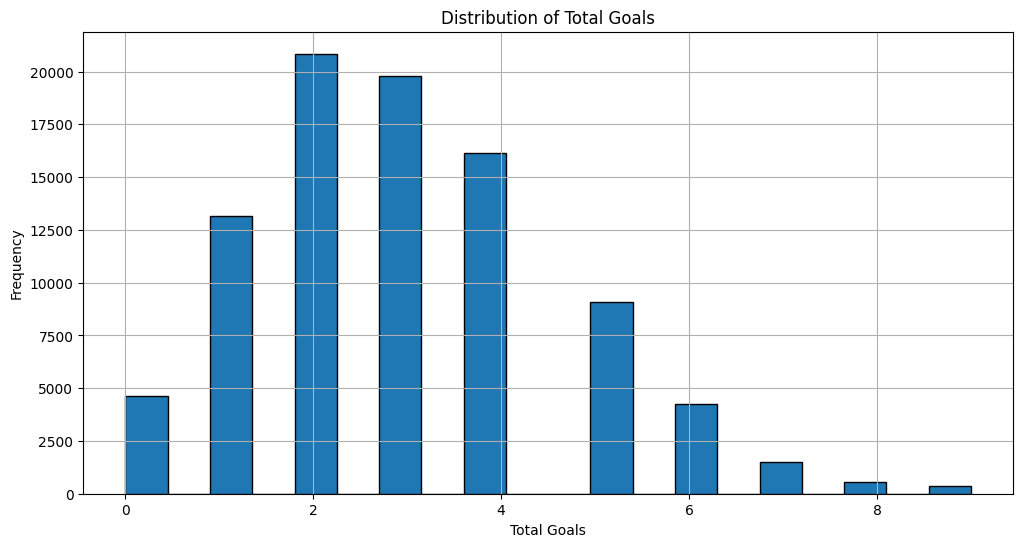

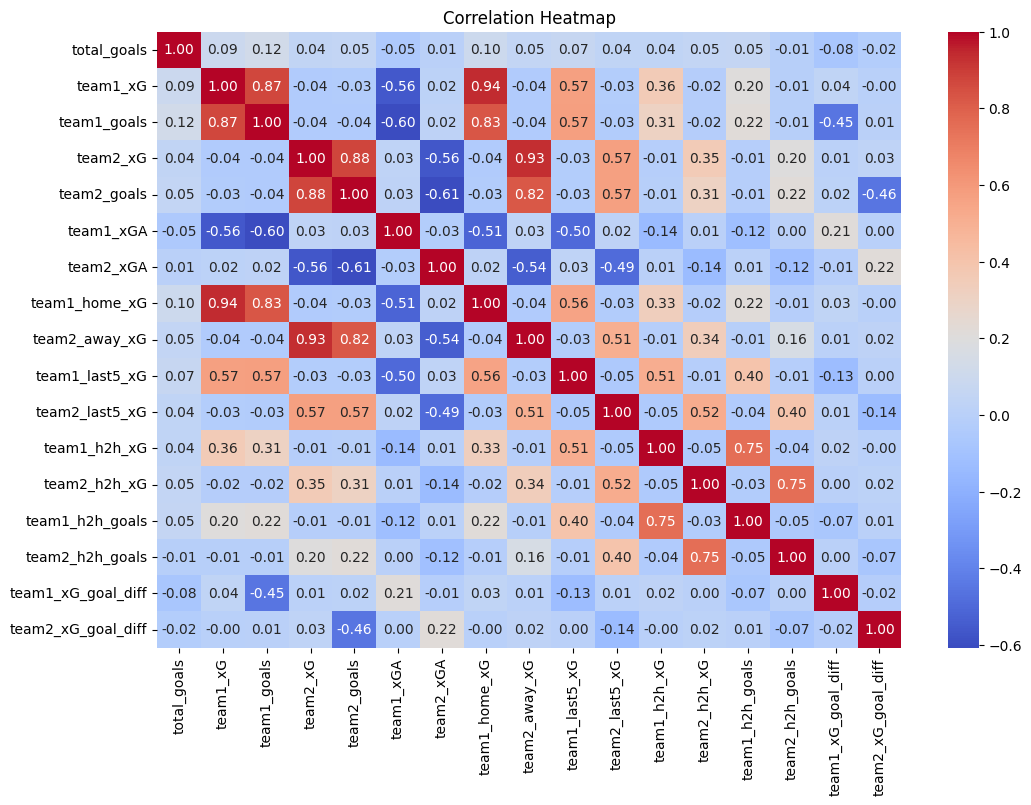

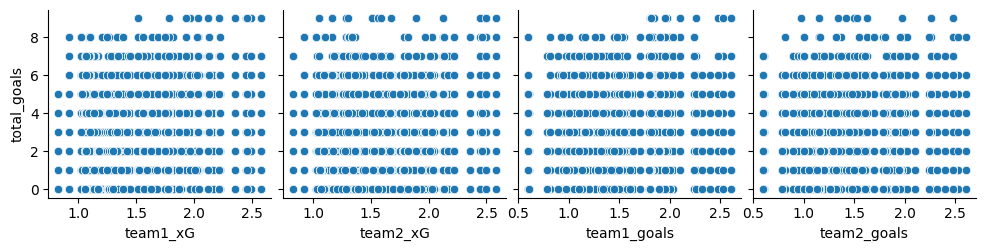

In [7]:
#EDA PART
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data
conn = sqlite3.connect('premier_league_detailed.db')
query = """
    SELECT 
        m.home_team AS team1, m.away_team AS team2, 
        (m.home_goals + m.away_goals) AS total_goals,
        th1.avg_xG AS team1_xG, th1.avg_goals AS team1_goals,
        th2.avg_xG AS team2_xG, th2.avg_goals AS team2_goals,
        th1.defensive_xGA AS team1_xGA, th2.defensive_xGA AS team2_xGA,
        th1.home_avg_xG AS team1_home_xG, th2.away_avg_xG AS team2_away_xG,
        th1.last5_avg_xG AS team1_last5_xG, th2.last5_avg_xG AS team2_last5_xG,
        th1.h2h_avg_xG AS team1_h2h_xG, th2.h2h_avg_xG AS team2_h2h_xG,
        th1.h2h_avg_goals AS team1_h2h_goals, th2.h2h_avg_goals AS team2_h2h_goals,
        (th1.avg_xG - th1.avg_goals) AS team1_xG_goal_diff,
        (th2.avg_xG - th2.avg_goals) AS team2_xG_goal_diff
    FROM Matches m
    JOIN TeamMetrics th1 ON m.home_team = th1.team
    JOIN TeamMetrics th2 ON m.away_team = th2.team
"""
data = pd.read_sql_query(query, conn)
conn.close()

# 1. Basic Overview
print("Data Shape:", data.shape)
print("Data Types:\n", data.dtypes)
print("Missing Values:\n", data.isnull().sum())
print("First Few Rows:\n", data.head())

# 2. Summary Statistics
print("\nSummary Statistics:\n", data.describe())

# 3. Distribution Analysis
plt.figure(figsize=(12, 6))
data['total_goals'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Total Goals')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.show()

# Exclude non-numeric columns
numeric_data = data.select_dtypes(include=['number'])

# 4. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# 5. Feature-Target Relationships
sns.pairplot(data, y_vars='total_goals', x_vars=['team1_xG', 'team2_xG', 'team1_goals', 'team2_goals'])
plt.show()

In [8]:
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare training data with metrics
def prepare_training_data_with_metrics():
    conn = sqlite3.connect('premier_league_detailed.db')

    # SQL query to fetch data
    query = """
    SELECT 
        m.home_team AS team1, m.away_team AS team2, 
        (m.home_goals + m.away_goals) AS total_goals,
        th1.avg_xG AS team1_xG, th1.avg_goals AS team1_goals,
        th2.avg_xG AS team2_xG, th2.avg_goals AS team2_goals,
        th1.defensive_xGA AS team1_xGA, th2.defensive_xGA AS team2_xGA,
        th1.home_avg_xG AS team1_home_xG, th2.away_avg_xG AS team2_away_xG,
        th1.last5_avg_xG AS team1_last5_xG, th2.last5_avg_xG AS team2_last5_xG,
        th1.h2h_avg_xG AS team1_h2h_xG, th2.h2h_avg_xG AS team2_h2h_xG,
        th1.h2h_avg_goals AS team1_h2h_goals, th2.h2h_avg_goals AS team2_h2h_goals,
        (th1.avg_xG - th1.avg_goals) AS team1_xG_goal_diff,
        (th2.avg_xG - th2.avg_goals) AS team2_xG_goal_diff
    FROM Matches m
    JOIN TeamMetrics th1 ON m.home_team = th1.team
    JOIN TeamMetrics th2 ON m.away_team = th2.team
    """
    data = pd.read_sql_query(query, conn)
    conn.close()

    # Separate features (X) and target variable (y)
    X = data[['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
              'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
              'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
              'team1_xG_goal_diff', 'team2_xG_goal_diff']].values
    y = data['total_goals'].values

    return X, y

# Fetch data
X, y = prepare_training_data_with_metrics()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print a summary of the dataset
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Feature names:")
print(['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
       'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
       'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
       'team1_xG_goal_diff', 'team2_xG_goal_diff'])

Training set size: (72220, 16)
Test set size: (18056, 16)
Feature names:
['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG', 'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG', 'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals', 'team1_xG_goal_diff', 'team2_xG_goal_diff']


In [11]:
#XG Boost
# XGBoost Evaluation:
# MAE: 1.06
# MSE: 1.81
# R² Score: 0.37
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.2f}")

XGBoost Evaluation:
MAE: 1.06
MSE: 1.81
R² Score: 0.37


In [17]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_training_data_with_metrics():
    conn = sqlite3.connect('premier_league_detailed.db')

    query = """
    SELECT 
        m.home_team AS team1, m.away_team AS team2, 
        (m.home_goals + m.away_goals) AS total_goals,
        th1.avg_xG AS team1_xG, th1.avg_goals AS team1_goals,
        th2.avg_xG AS team2_xG, th2.avg_goals AS team2_goals,
        th1.defensive_xGA AS team1_xGA, th2.defensive_xGA AS team2_xGA,
        th1.home_avg_xG AS team1_home_xG, th2.away_avg_xG AS team2_away_xG,
        th1.last5_avg_xG AS team1_last5_xG, th2.last5_avg_xG AS team2_last5_xG,
        th1.h2h_avg_xG AS team1_h2h_xG, th2.h2h_avg_xG AS team2_h2h_xG,
        th1.h2h_avg_goals AS team1_h2h_goals, th2.h2h_avg_goals AS team2_h2h_goals,
        (th1.avg_xG - th1.avg_goals) AS team1_xG_goal_diff,
        (th2.avg_xG - th2.avg_goals) AS team2_xG_goal_diff
    FROM Matches m
    JOIN TeamMetrics th1 ON m.home_team = th1.team
    JOIN TeamMetrics th2 ON m.away_team = th2.team
    """
    data = pd.read_sql_query(query, conn)
    conn.close()

    X = data[['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
              'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
              'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
              'team1_xG_goal_diff', 'team2_xG_goal_diff']].values
    y = data['total_goals'].values

    return X, y

def add_features(data, matches):
    recent_form = {}
    h2h_stats = {}
    venue_stats = {}

    def calculate_recent_form(team, match_date, n=5):
        recent_matches = matches[(matches['date'] < match_date) & 
                                 ((matches['home_team'] == team) | (matches['away_team'] == team))].tail(n)
        goals_scored = recent_matches.apply(lambda row: row['home_goals'] if row['home_team'] == team else row['away_goals'], axis=1).mean()
        goals_conceded = recent_matches.apply(lambda row: row['away_goals'] if row['home_team'] == team else row['home_goals'], axis=1).mean()
        win_percentage = recent_matches.apply(lambda row: 1 if (row['home_team'] == team and row['home_goals'] > row['away_goals']) or 
                                                     (row['away_team'] == team and row['away_goals'] > row['home_goals']) else 0, axis=1).mean()
        return goals_scored, goals_conceded, win_percentage

    def calculate_h2h(team1, team2):
        h2h_matches = matches[((matches['home_team'] == team1) & (matches['away_team'] == team2)) |
                              ((matches['home_team'] == team2) & (matches['away_team'] == team1))]
        goals_scored = h2h_matches.apply(lambda row: row['home_goals'] if row['home_team'] == team1 else row['away_goals'], axis=1).mean()
        goals_conceded = h2h_matches.apply(lambda row: row['away_goals'] if row['home_team'] == team1 else row['home_goals'], axis=1).mean()
        return goals_scored, goals_conceded

    def calculate_venue_stats(team, venue):
        venue_matches = matches[(matches['home_team'] == team) & (venue == 'home') |
                                (matches['away_team'] == team) & (venue == 'away')]
        avg_goals = venue_matches.apply(lambda row: row['home_goals'] if venue == 'home' else row['away_goals'], axis=1).mean()
        avg_conceded = venue_matches.apply(lambda row: row['away_goals'] if venue == 'home' else row['home_goals'], axis=1).mean()
        return avg_goals, avg_conceded

    for _, row in data.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        match_date = row['date']

        if team1 not in recent_form:
            recent_form[team1] = calculate_recent_form(team1, match_date)
        if team2 not in recent_form:
            recent_form[team2] = calculate_recent_form(team2, match_date)
        data.at[_, 'team1_recent_goals'] = recent_form[team1][0]
        data.at[_, 'team1_recent_conceded'] = recent_form[team1][1]
        data.at[_, 'team1_win_percentage'] = recent_form[team1][2]
        data.at[_, 'team2_recent_goals'] = recent_form[team2][0]
        data.at[_, 'team2_recent_conceded'] = recent_form[team2][1]
        data.at[_, 'team2_win_percentage'] = recent_form[team2][2]

        if (team1, team2) not in h2h_stats:
            h2h_stats[(team1, team2)] = calculate_h2h(team1, team2)
        data.at[_, 'team1_h2h_recent_goals'] = h2h_stats[(team1, team2)][0]
        data.at[_, 'team1_h2h_recent_conceded'] = h2h_stats[(team1, team2)][1]

        if (team1, 'home') not in venue_stats:
            venue_stats[(team1, 'home')] = calculate_venue_stats(team1, 'home')
        if (team2, 'away') not in venue_stats:
            venue_stats[(team2, 'away')] = calculate_venue_stats(team2, 'away')
        data.at[_, 'team1_home_goals'] = venue_stats[(team1, 'home')][0]
        data.at[_, 'team1_home_conceded'] = venue_stats[(team1, 'home')][1]
        data.at[_, 'team2_away_goals'] = venue_stats[(team2, 'away')][0]
        data.at[_, 'team2_away_conceded'] = venue_stats[(team2, 'away')][1]

    return data

# Load matches
conn = sqlite3.connect('premier_league_detailed.db')
matches = pd.read_sql_query("SELECT * FROM Matches", conn)
conn.close()

# Convert string columns to numeric
matches['home_goals'] = pd.to_numeric(matches['home_goals'])
matches['away_goals'] = pd.to_numeric(matches['away_goals'])
matches['home_xG'] = pd.to_numeric(matches['home_xG'])
matches['away_xG'] = pd.to_numeric(matches['away_xG'])

# Prepare data for feature engineering
X, y = prepare_training_data_with_metrics()
X_df = pd.DataFrame(X, columns=[
    'team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
    'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
    'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
    'team1_xG_goal_diff', 'team2_xG_goal_diff'
])
X_df['date'] = matches['date']
X_df['team1'] = matches['home_team']
X_df['team2'] = matches['away_team']

# Add engineered features
X_enhanced = add_features(X_df, matches)
X_enhanced.drop(['date', 'team1', 'team2'], axis=1, inplace=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Feature engineering and data preparation complete!")

Feature engineering and data preparation complete!


c:\Users\aliku\anaconda3\envs\understat_env\lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\aliku\anaconda3\envs\understat_env\lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\aliku\anaconda3\envs\understat_env\lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [18]:
#BEST MODEL SO FAR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import numpy as np

# Base models
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
lgbm = LGBMRegressor(random_state=42)

# Parameter grids for hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}

# Hyperparameter tuning for XGBoost
print("Tuning XGBoost...")
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb = xgb_grid_search.best_estimator_
print("Best XGBoost params:", xgb_grid_search.best_params_)

# Hyperparameter tuning for LightGBM
print("\nTuning LightGBM...")
lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
lgbm_grid_search.fit(X_train, y_train)
best_lgbm = lgbm_grid_search.best_estimator_
print("Best LightGBM params:", lgbm_grid_search.best_params_)

# Stacking Regressor with tuned base models
print("\nTuning Stacked Regressor...")
base_models = [('xgb', best_xgb), ('lgbm', best_lgbm)]
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Hyperparameter tuning for the final estimator (Ridge)
stacking_grid_search = GridSearchCV(estimator=stacking_regressor, param_grid={'final_estimator__alpha': ridge_param_grid['alpha']}, cv=3, scoring='r2', verbose=2, n_jobs=-1)
stacking_grid_search.fit(X_train, y_train)
best_stacking_model = stacking_grid_search.best_estimator_

# Predictions and evaluation
y_pred_stacked = best_stacking_model.predict(X_test)

print("\nFinal Stacked Model Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_stacked):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_stacked):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_stacked):.2f}")

Tuning XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best XGBoost params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

Tuning LightGBM...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\aliku\anaconda3\envs\understat_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\aliku\anaconda3\envs\understat_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 72220, number of used features: 22
[LightGBM] [Info] Start training from score 2.963279
Best LightGBM params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'subsample': 0.8}

Tuning Stacked Regressor...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 72220, number of used features: 22
[LightGBM] [Info] Start training from score 2.963279

In [19]:
print("XGBoost Feature Importances:", best_xgb.feature_importances_)
print("LightGBM Feature Importances:", best_lgbm.feature_importances_)

XGBoost Feature Importances: [0.01498756 0.05644813 0.03343244 0.04098722 0.0910365  0.01596794
 0.04751553 0.03458193 0.04414047 0.08597806 0.08388405 0.0927474
 0.1069137  0.11499271 0.02932569 0.04091099 0.         0.
 0.         0.         0.         0.         0.01322707 0.02053036
 0.00774633 0.0061035  0.00779345 0.01074897]
LightGBM Feature Importances: [ 542  359  442  292 1107  572  311  347  335 1357  791  804  286  315
  220  249    0    0    0    0    0    0  223  147   78   76   55   92]


In [23]:
import pickle

# Save the trained model
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_stacking_model, model_file)

# Save the scaler
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [9]:
# #Linear Regression
# Model Evaluation:
# Mean Absolute Error (MAE): 1.33
# Mean Squared Error (MSE): 2.77
# R² Score: 0.03
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Initialize the model
# model = LinearRegression()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Model Evaluation:")
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"R² Score: {r2:.2f}")

In [10]:
# #Random Forest
# Random Forest Evaluation:
# MAE: 1.08
# MSE: 1.95
# R² Score: 0.32
# from sklearn.ensemble import RandomForestRegressor

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# y_pred_rf = rf_model.predict(X_test)

# print("Random Forest Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_rf):.2f}")

In [12]:
# #LightGBM
# LightGBM Evaluation:
# MAE: 1.10
# MSE: 1.89
# R² Score: 0.34
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Define and train the LightGBM model
# lgbm = LGBMRegressor(random_state=42)
# lgbm.fit(X_train, y_train)

# # Predictions
# y_pred_lgbm = lgbm.predict(X_test)

# # Evaluate the model
# print("LightGBM Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_lgbm):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_lgbm):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_lgbm):.2f}")

In [13]:
# #Neural Network
# Neural Network MAE: 1.11
# Neural Network R² Score: 0.32
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Define the model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1)  # Single output for regression
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# # Evaluate the model
# loss, mae = model.evaluate(X_test, y_test, verbose=0)
# print(f"Neural Network MAE: {mae:.2f}")

# # Predict and calculate R² score
# y_pred_nn = model.predict(X_test).flatten()
# print(f"Neural Network R² Score: {r2_score(y_test, y_pred_nn):.2f}")

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from xgboost import XGBRegressor

# # Define the XGBRegressor
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Perform Grid Search
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best R² score from GridSearch:", grid_search.best_score_)

# # Train final model with best parameters
# best_xgb = grid_search.best_estimator_
# y_pred_best = best_xgb.predict(X_test)

# # Evaluate final model
# print("Tuned XGBoost Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_best):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_best):.2f}")

In [15]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Define base models
# base_models = [
#     ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=300, max_depth=7, learning_rate=0.05)),
#     ('lgbm', LGBMRegressor(random_state=42, n_estimators=300, max_depth=7, learning_rate=0.05)),
#     ('catboost', CatBoostRegressor(iterations=300, learning_rate=0.05, depth=7, random_state=42, verbose=0))
# ]

# # Define the stacking regressor
# stacked = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# # Train the stacked model
# stacked.fit(X_train, y_train)

# # Predict and evaluate
# y_pred_stacked = stacked.predict(X_test)

# # Evaluate the model
# print("Stacked Model Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_stacked):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_stacked):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_stacked):.2f}")

In [16]:
# #BEST MODEL SO FAR
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# import numpy as np

# # Base models
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# lgbm = LGBMRegressor(random_state=42)

# # Parameter grids for hyperparameter tuning
# xgb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# lgbm_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [-1, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0]
# }

# ridge_param_grid = {
#     'alpha': [0.1, 1.0, 10.0]
# }

# # Hyperparameter tuning for XGBoost
# print("Tuning XGBoost...")
# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# xgb_grid_search.fit(X_train, y_train)
# best_xgb = xgb_grid_search.best_estimator_
# print("Best XGBoost params:", xgb_grid_search.best_params_)

# # Hyperparameter tuning for LightGBM
# print("\nTuning LightGBM...")
# lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# lgbm_grid_search.fit(X_train, y_train)
# best_lgbm = lgbm_grid_search.best_estimator_
# print("Best LightGBM params:", lgbm_grid_search.best_params_)

# # Stacking Regressor with tuned base models
# print("\nTuning Stacked Regressor...")
# base_models = [('xgb', best_xgb), ('lgbm', best_lgbm)]
# stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# # Hyperparameter tuning for the final estimator (Ridge)
# stacking_grid_search = GridSearchCV(estimator=stacking_regressor, param_grid={'final_estimator__alpha': ridge_param_grid['alpha']}, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# stacking_grid_search.fit(X_train, y_train)
# best_stacking_model = stacking_grid_search.best_estimator_

# # Predictions and evaluation
# y_pred_stacked = best_stacking_model.predict(X_test)

# print("\nFinal Stacked Model Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_stacked):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_stacked):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_stacked):.2f}")

In [20]:
# import pandas as pd
# import numpy as np
# import sqlite3
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor

# # Updated function to exclude low-importance features
# def prepare_training_data_with_metrics():
#     conn = sqlite3.connect('premier_league_detailed.db')

#     query = """
#     SELECT 
#         m.home_team AS team1, m.away_team AS team2, 
#         (m.home_goals + m.away_goals) AS total_goals,
#         th1.avg_xG AS team1_xG, th1.avg_goals AS team1_goals,
#         th2.avg_xG AS team2_xG, th2.avg_goals AS team2_goals,
#         th1.defensive_xGA AS team1_xGA, th2.defensive_xGA AS team2_xGA,
#         th1.home_avg_xG AS team1_home_xG, th2.away_avg_xG AS team2_away_xG,
#         th1.last5_avg_xG AS team1_last5_xG, th2.last5_avg_xG AS team2_last5_xG,
#         th1.h2h_avg_xG AS team1_h2h_xG, th2.h2h_avg_xG AS team2_h2h_xG,
#         th1.h2h_avg_goals AS team1_h2h_goals, th2.h2h_avg_goals AS team2_h2h_goals
#     FROM Matches m
#     JOIN TeamMetrics th1 ON m.home_team = th1.team
#     JOIN TeamMetrics th2 ON m.away_team = th2.team
#     """
#     data = pd.read_sql_query(query, conn)
#     conn.close()

#     # Exclude low-importance features
#     X = data[['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
#               'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
#               'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals']].values
#     y = data['total_goals'].values

#     return X, y

# # Prepare refined data
# X, y = prepare_training_data_with_metrics()
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Define base models and stacking regressor
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# lgbm = LGBMRegressor(random_state=42)

# xgb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# lgbm_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [-1, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0]
# }

# ridge_param_grid = {
#     'alpha': [0.1, 1.0, 10.0]
# }

# # Hyperparameter tuning for XGBoost
# print("Tuning XGBoost...")
# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# xgb_grid_search.fit(X_train, y_train)
# best_xgb = xgb_grid_search.best_estimator_
# print("Best XGBoost params:", xgb_grid_search.best_params_)

# # Hyperparameter tuning for LightGBM
# print("\nTuning LightGBM...")
# lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# lgbm_grid_search.fit(X_train, y_train)
# best_lgbm = lgbm_grid_search.best_estimator_
# print("Best LightGBM params:", lgbm_grid_search.best_params_)

# # Stacking Regressor
# print("\nTuning Stacked Regressor...")
# base_models = [('xgb', best_xgb), ('lgbm', best_lgbm)]
# stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# stacking_grid_search = GridSearchCV(estimator=stacking_regressor, param_grid={'final_estimator__alpha': ridge_param_grid['alpha']}, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# stacking_grid_search.fit(X_train, y_train)
# best_stacking_model = stacking_grid_search.best_estimator_

# # Predictions and evaluation
# y_pred_stacked = best_stacking_model.predict(X_test)

# print("\nFinal Stacked Model Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_stacked):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_stacked):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_stacked):.2f}")

In [21]:
# import pandas as pd
# import numpy as np
# import sqlite3
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor

# # Updated function to include previously removed features
# def prepare_training_data_with_metrics():
#     conn = sqlite3.connect('premier_league_detailed.db')

#     query = """
#     SELECT 
#         m.home_team AS team1, m.away_team AS team2, 
#         (m.home_goals + m.away_goals) AS total_goals,
#         th1.avg_xG AS team1_xG, th1.avg_goals AS team1_goals,
#         th2.avg_xG AS team2_xG, th2.avg_goals AS team2_goals,
#         th1.defensive_xGA AS team1_xGA, th2.defensive_xGA AS team2_xGA,
#         th1.home_avg_xG AS team1_home_xG, th2.away_avg_xG AS team2_away_xG,
#         th1.last5_avg_xG AS team1_last5_xG, th2.last5_avg_xG AS team2_last5_xG,
#         th1.h2h_avg_xG AS team1_h2h_xG, th2.h2h_avg_xG AS team2_h2h_xG,
#         th1.h2h_avg_goals AS team1_h2h_goals, th2.h2h_avg_goals AS team2_h2h_goals,
#         (th1.avg_xG - th1.avg_goals) AS team1_xG_goal_diff,
#         (th2.avg_xG - th2.avg_goals) AS team2_xG_goal_diff
#     FROM Matches m
#     JOIN TeamMetrics th1 ON m.home_team = th1.team
#     JOIN TeamMetrics th2 ON m.away_team = th2.team
#     """
#     data = pd.read_sql_query(query, conn)
#     conn.close()

#     # Include all features, including goal differences
#     X = data[['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
#               'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
#               'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
#               'team1_xG_goal_diff', 'team2_xG_goal_diff']].values
#     y = data['total_goals'].values

#     return X, y

# # Prepare data
# X, y = prepare_training_data_with_metrics()
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Define base models and stacking regressor
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# lgbm = LGBMRegressor(random_state=42)

# xgb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# lgbm_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [-1, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0]
# }

# ridge_param_grid = {
#     'alpha': [0.1, 1.0, 10.0]
# }

# # Hyperparameter tuning for XGBoost
# print("Tuning XGBoost...")
# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# xgb_grid_search.fit(X_train, y_train)
# best_xgb = xgb_grid_search.best_estimator_
# print("Best XGBoost params:", xgb_grid_search.best_params_)

# # Hyperparameter tuning for LightGBM
# print("\nTuning LightGBM...")
# lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# lgbm_grid_search.fit(X_train, y_train)
# best_lgbm = lgbm_grid_search.best_estimator_
# print("Best LightGBM params:", lgbm_grid_search.best_params_)

# # Stacking Regressor
# print("\nTuning Stacked Regressor...")
# base_models = [('xgb', best_xgb), ('lgbm', best_lgbm)]
# stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# stacking_grid_search = GridSearchCV(estimator=stacking_regressor, param_grid={'final_estimator__alpha': ridge_param_grid['alpha']}, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# stacking_grid_search.fit(X_train, y_train)
# best_stacking_model = stacking_grid_search.best_estimator_

# # Predictions and evaluation
# y_pred_stacked = best_stacking_model.predict(X_test)

# print("\nFinal Stacked Model Evaluation:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_stacked):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_stacked):.2f}")
# print(f"R² Score: {r2_score(y_test, y_pred_stacked):.2f}")

In [22]:
# import pandas as pd
# import numpy as np
# import sqlite3
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor

# # Prepare training data with metrics
# def prepare_training_data_with_metrics():
#     conn = sqlite3.connect('premier_league_detailed.db')

#     query = """
#     SELECT 
#         m.home_team AS team1, m.away_team AS team2, 
#         (m.home_goals + m.away_goals) AS total_goals,
#         th1.avg_xG AS team1_xG, th1.avg_goals AS team1_goals,
#         th2.avg_xG AS team2_xG, th2.avg_goals AS team2_goals,
#         th1.defensive_xGA AS team1_xGA, th2.defensive_xGA AS team2_xGA,
#         th1.home_avg_xG AS team1_home_xG, th2.away_avg_xG AS team2_away_xG,
#         th1.last5_avg_xG AS team1_last5_xG, th2.last5_avg_xG AS team2_last5_xG,
#         th1.h2h_avg_xG AS team1_h2h_xG, th2.h2h_avg_xG AS team2_h2h_xG,
#         th1.h2h_avg_goals AS team1_h2h_goals, th2.h2h_avg_goals AS team2_h2h_goals,
#         (th1.avg_xG - th1.avg_goals) AS team1_xG_goal_diff,
#         (th2.avg_xG - th2.avg_goals) AS team2_xG_goal_diff
#     FROM Matches m
#     JOIN TeamMetrics th1 ON m.home_team = th1.team
#     JOIN TeamMetrics th2 ON m.away_team = th2.team
#     """
#     data = pd.read_sql_query(query, conn)
#     conn.close()

#     X = data[['team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
#               'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
#               'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
#               'team1_xG_goal_diff', 'team2_xG_goal_diff']].values
#     y = data['total_goals'].values

#     return X, y, data

# # Add interaction features
# def add_interaction_features(data):
#     data['xG_ratio'] = data['team1_xG'] / (data['team2_xG'] + 1e-5)
#     data['goal_ratio'] = data['team1_goals'] / (data['team2_goals'] + 1)
#     data['recent_form_diff'] = data['team1_last5_xG'] - data['team2_last5_xG']
#     data['h2h_xG_diff'] = data['team1_h2h_xG'] - data['team2_h2h_xG']
#     return data

# # Main workflow
# def main():
#     # Load data
#     X, y, original_data = prepare_training_data_with_metrics()

#     # Convert to DataFrame for easier feature manipulation
#     X_df = pd.DataFrame(X, columns=[
#         'team1_xG', 'team1_goals', 'team1_xGA', 'team1_home_xG', 'team1_last5_xG',
#         'team2_xG', 'team2_goals', 'team2_xGA', 'team2_away_xG', 'team2_last5_xG',
#         'team1_h2h_xG', 'team2_h2h_xG', 'team1_h2h_goals', 'team2_h2h_goals',
#         'team1_xG_goal_diff', 'team2_xG_goal_diff'
#     ])

#     # Add interaction features
#     X_enhanced = add_interaction_features(X_df)

#     # Scale features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_enhanced)

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#     # Base models
#     xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
#     lgbm = LGBMRegressor(random_state=42)

#     # Parameter grids
#     xgb_param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [3, 5, 7],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'subsample': [0.8, 1.0],
#         'colsample_bytree': [0.8, 1.0]
#     }

#     lgbm_param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [-1, 5, 7],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'subsample': [0.8, 1.0]
#     }

#     ridge_param_grid = {
#         'alpha': [0.1, 1.0, 10.0]
#     }

#     # Tuning and training
#     print("Tuning XGBoost...")
#     xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
#     xgb_grid_search.fit(X_train, y_train)
#     best_xgb = xgb_grid_search.best_estimator_
#     print("Best XGBoost params:", xgb_grid_search.best_params_)

#     print("\nTuning LightGBM...")
#     lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
#     lgbm_grid_search.fit(X_train, y_train)
#     best_lgbm = lgbm_grid_search.best_estimator_
#     print("Best LightGBM params:", lgbm_grid_search.best_params_)

#     print("\nTraining Stacked Regressor...")
#     base_models = [('xgb', best_xgb), ('lgbm', best_lgbm)]
#     stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))

#     stacking_regressor.fit(X_train, y_train)
#     y_pred_stacked = stacking_regressor.predict(X_test)

#     # Evaluation
#     print("\nFinal Stacked Model Evaluation:")
#     print(f"MAE: {mean_absolute_error(y_test, y_pred_stacked):.2f}")
#     print(f"MSE: {mean_squared_error(y_test, y_pred_stacked):.2f}")
#     print(f"R² Score: {r2_score(y_test, y_pred_stacked):.2f}")

# # Run the workflow
# main()